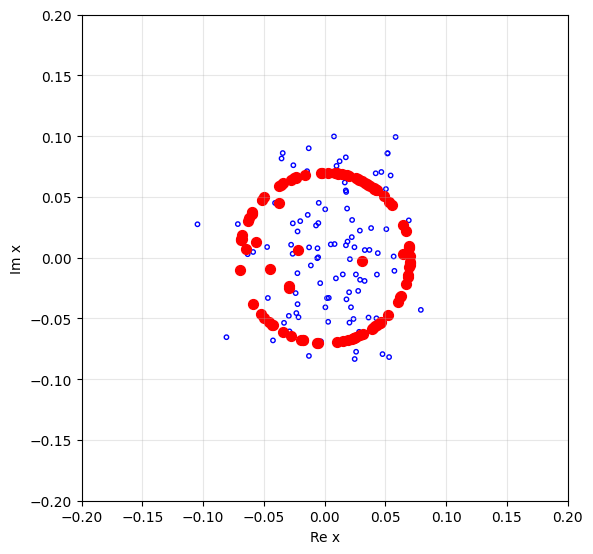

In [15]:
#compare norm_num with norm_inf

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# randn('state',0) 에 해당
np.random.seed(0)

# 차원 설정
m = 30
n = 100

# generate matrix A
Are = np.random.randn(m, n)
Aim = np.random.randn(m, n)
bre = np.random.randn(m, 1)
bim = np.random.randn(m, 1)
A = Are + 1j * Aim
b = bre + 1j * bim

# 2-norm problem (analytical solution)
Atot = np.block([[Are, -Aim],
                 [Aim,  Are]])
btot = np.vstack([bre, bim])
z_2 = Atot.T @ np.linalg.inv(Atot @ Atot.T) @ btot
x_2 = z_2[0:100] + 1j * z_2[100:200]

# 2-norm problem solution
# cvx_begin
x = cp.Variable(n, complex=True)
objective = cp.Minimize(cp.norm(x))
constraints = [A @ x == b.flatten()]
prob = cp.Problem(objective, constraints)
prob.solve()
# cvx_end

# inf-norm problem solution
# cvx_begin
xinf = cp.Variable(n, complex=True)
objective_inf = cp.Minimize(cp.norm(xinf, 'inf'))
constraints_inf = [A @ xinf == b.flatten()]
prob_inf = cp.Problem(objective_inf, constraints_inf)
prob_inf.solve()
# cvx_end

# scatter plot
# figure(1)
plt.figure(1, figsize=(6, 6))
plt.scatter(np.real(x.value), np.imag(x.value), facecolors='none', edgecolors='blue', s=10)
plt.scatter(np.real(xinf.value), np.imag(xinf.value), c='red', s=50)
plt.axis([-0.2, 0.2, -0.2, 0.2])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Re x')
plt.ylabel('Im x')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# dual problem

import numpy as np
import cvxpy as cp

Q = np.array([[1, -1/2],
              [-1/2, 2]])
f = np.array([-1, 0]).T
A = np.array([[1, 2],
              [1, -4],
              [5, 76]])
b = np.array([-2, -3, 1]).T

# cvx_begin
x = cp.Variable(2)
# dual variable lambda
constraints = [A @ x <= b]
objective = cp.Minimize(cp.quad_form(x, Q) + f.T @ x)
prob = cp.Problem(objective, constraints)
prob.solve()
# cvx_end

# dual variable
lambda_dual = constraints[0].dual_value

p_star = prob.value

print(f"p_star = {p_star}")
print(f"x = {x.value}")
print(f"lambda = {lambda_dual}")

p_star = 8.222222222222221
x = [-2.33333333  0.16666667]
lambda = [2.74774125 2.88523345 0.04007173]


In [17]:
# dual problem: linear approximation sensitivity analysis

arr_i = {-0.1, 0, 0.1}
pa_table = []

for i in arr_i:
    for j in arr_i:
        p_pred = p_star - np.array([lambda_dual[0], lambda_dual[1]]) @ np.array([i, j])

        x = cp.Variable(2)
        objective = cp.Minimize(cp.quad_form(x, Q) + f.T @ x)
        constraints = [A @ x <= b + np.array([i, j, 0])]
        prob = cp.Problem(objective, constraints)
        prob.solve()

        p_exact = prob.value

        pa_table.append([i, j, p_pred, p_exact])

pa_table = np.array(pa_table)
print("\n   Δb1      Δb2      p_pred   p_exact")
print("=" * 45)
for row in pa_table:
    print(f"{row[0]:7.2f}   {row[1]:7.2f}   {row[2]:8.4f}   {row[3]:8.4f}")


   Δb1      Δb2      p_pred   p_exact
  -0.10     -0.10     8.7855     8.8156
  -0.10      0.00     8.4970     8.5650
  -0.10      0.10     8.2085     8.3189
   0.00     -0.10     8.5107     8.7064
   0.00      0.00     8.2222     8.2222
   0.00      0.10     7.9337     7.9800
   0.10     -0.10     8.2360     8.7064
   0.10      0.00     7.9474     8.2222
   0.10      0.10     7.6589     7.7515


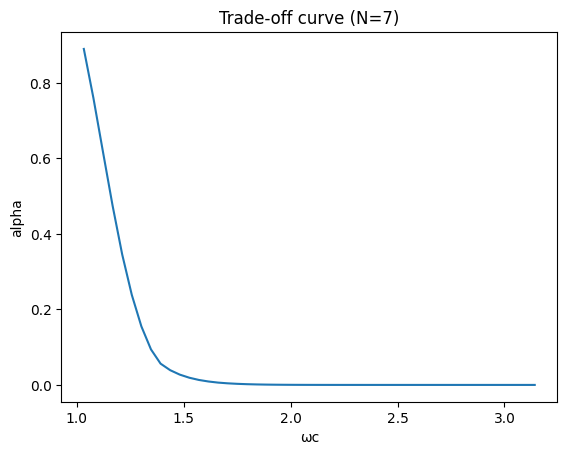

In [18]:
# FIR filter design.

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# 파라미터 설정
N = 7
K = 10 * N
k = np.arange(N+1).reshape(1, -1)   # shape (1, N+1)
w = np.linspace(0, np.pi, K+1)      # 0 ~ π 사이 K+1 점
idx = np.max(np.where(w <= np.pi/3))  # passband 구간 인덱스

alphas = []

# trade-off curve 계산
for i in range(idx, len(w)):
    # 변수: FIR 계수 a (길이 N+1)
    a = cp.Variable(N+1)

    # Stopband matrix (for w[i:] 구간)
    W_sb = w[i:].reshape(-1, 1)      # (len_sb, 1)
    C_sb = np.cos(W_sb @ k)          # shape (len_sb, N+1)

    # Passband matrix (for w[:idx+1] 구간)
    W_pb = w[:idx+1].reshape(-1, 1)
    C_pb = np.cos(W_pb @ k)

    # objective
    obj = cp.Minimize(cp.norm_inf(C_sb @ a))

    # constraints: passband
    constraints = [
        C_pb @ a >= 0.89,
        C_pb @ a <= 1.12
    ]

    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)  # ECOS나 SCS 가능

    alphas.append(prob.value)

# 결과
plt.plot(w[idx:], alphas, '-')
plt.xlabel("ωc")
plt.ylabel("alpha")
plt.title("Trade-off curve (N=7)")
plt.show()


Optimal value: 17.32356785419719
u(t): [[ 1.46483659e-11  2.37404353e-11 -1.04882481e-09  1.00000000e+00
  -1.00000000e+00  1.00000000e+00 -6.02436519e-11  5.98191203e-13
   5.89256352e-11 -1.00000000e+00  1.00000000e+00 -1.00000000e+00
   2.46624155e-01 -2.05256161e-11 -1.06266670e-11  1.78279297e-10
  -1.00000000e+00  1.00000000e+00 -1.00000000e+00  1.33424646e-10
  -8.58520744e-13 -1.71192927e-11  1.00000000e+00 -6.98881473e-01
   1.00000000e+00 -4.72804723e-11  1.53597304e-09  5.66872166e-11
   8.15084298e-12  3.18903111e+00]]


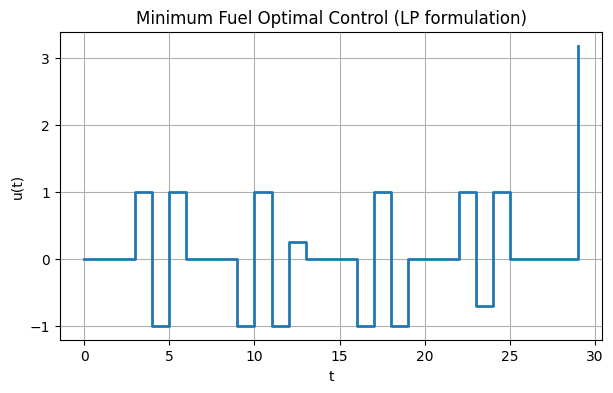

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# settings
n = 3
N = 30
A = np.array([[-1, 0.4, 0.8],
              [1, 0, 0],
              [0, 1, 0]])
b = np.array([[1], [0], [0.3]])
x0 = np.zeros((n, 1))
x_des = np.array([[7], [2], [-6]])

# variables
X = cp.Variable((n, N+1))
u = cp.Variable((1, N))
s = cp.Variable((1, N))

# objective (1^T s)
obj = cp.Minimize(cp.sum(s))

# constraints
constraints = [
    X[:, 1:N+1] == A @ X[:, 0:N] + b @ u,
    X[:, 0] == x0.flatten(),
    X[:, N] == x_des.flatten(),
    s >= 2*u - 1,
    s >= -2*u - 1,
    s >= u,
    s >= -u
]

# solve
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS)

print("Optimal value:", prob.value)
print("u(t):", u.value)

# plot result
plt.figure(figsize=(7,4))
plt.step(np.arange(N), u.value.flatten(), where='post', linewidth=2)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Minimum Fuel Optimal Control (LP formulation)")
plt.grid(True)
plt.show()
